
Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

Images: 11
Classes: ['BG', 'leaf']
Loading weights  /hdd/gros2/maskrcnn/logs/leaves_model20230820T1047/mask_rcnn_leaves_model_0029.h5
Re-starting from epoch 29
{'id': '2023-01-31_08.jpg', 'source': 'leaf', 'path': '/hdd/gros2/maskrcnn/samples/senior_thesis_project/3-model/dataset/val/2023-01-31_08.jpg', 'width': 2208, 'height': 1242, 'polygons': [{'name': 'polygon', 'all_points_x': [1116, 1118, 1119, 1126, 1134, 1143, 1150, 1158, 1159, 1160, 1146, 1142, 1133, 1119, 1117, 1117, 1115], 'all_points_y': [1073, 1071, 1062, 1046, 1027, 1017, 1016, 1012, 1013, 1028, 1043, 1051, 1063, 1078, 1080, 1088, 1088]}, {'name': 'polygon', 'all_points_x': [1161, 1161, 1163, 1167, 1168, 1173, 1182, 1176, 1180, 1172, 1166], 'all_points_y': [1061, 1008, 989, 992, 1003, 1023, 1053, 1057, 1064, 1066, 1065]}, {'name': 'polygon', 'all_points_x': [1292, 1293, 1296, 1296, 1303, 1302, 1291, 1281, 1277, 1270, 1259, 1242, 1222, 1222, 1238, 1249, 1258, 1272], 'all_points_y': [1179, 1171, 1166, 1160, 1152, 1150, 1152

AssertionError: 

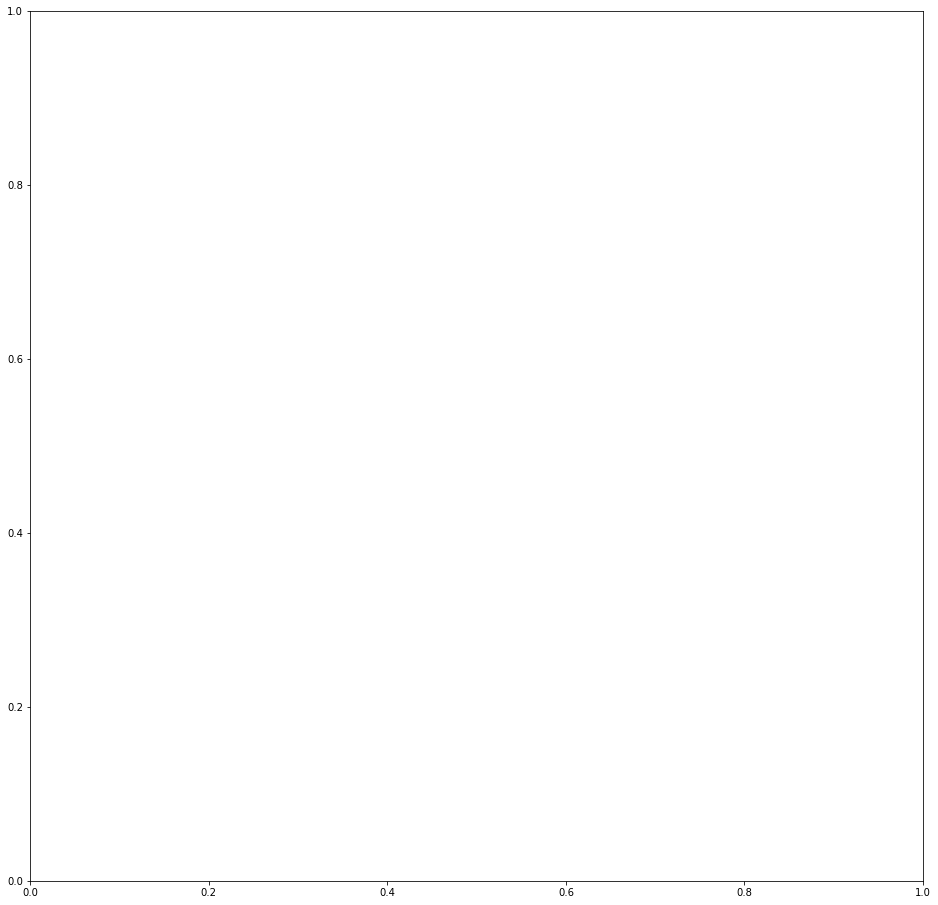

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pickle

# Root directory of the project
ROOT_DIR = os.path.abspath("../../../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import importlib
module_name = "samples.plants_to_leaf_area.3-model.src.leaves_model"
leaves_model_module = importlib.import_module(module_name)
leaves_model = leaves_model_module
# from samples.plants_to_leaf_area.3-model.src.leaves_model import leaves_model

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
LEAVES_MODEL_WEIGHTS_PATH = os.path.join(ROOT_DIR, "logs/leaves_model20230819T2343")  # TODO: update this path


config = leaves_model.LeavesConfig()
LEAVES_MODEL_DIR = os.path.join(ROOT_DIR, "samples/plants_to_leaf_area/3-model/dataset")

# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()

# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

# Load validation dataset
dataset = leaves_model.LeavesDataset()
dataset.load_leaves(LEAVES_MODEL_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))


# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
    

# Set path to leaves_model weights file
# weights_path = LEAVES_MODEL_WEIGHTS_PATH

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

# image_id = random.choice(dataset.image_ids)
image_id = 1
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print(info)
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))

# Run object detection
results = model.detect([image], verbose=1)

# Display results
ax = get_ax(1)
r = results[0]

mask_path = '../data/validation/mask.txt'

with open(mask_path, 'rb') as f:
    masks = pickle.load(f)

mask = masks[list(masks.keys())[0]]


visualize.display_instances(image, r['rois'], np.array(mask), r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)